# Lekce 11

In [40]:
import pandas

import numpy
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### Popis importů

* `TSNE` redukce dimenzionality (počtu sloupců) s využitím algoritmu TSNE, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
* `KMeans` shlukování s využitím algoritmu K-Means, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* `StandardScaler` - objekt pro normalizaci dat, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* `OneHotEncoder` provádí One Hot Encoding zadaných dat, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* `DecisionTreeClassifier` - klasifikátor využívající algoritmus rozhodovacího strumu, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* `GridSearchCV` hledá nejlepší parametry klasifikátoru ze zadaného rozsahu podle zadané metriky, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Křížová validace

Podívejme se ještě jednou a a důkladněji na to, jak funguje `GridSearchCV` a proč vrací jiné výsledky, než průchod cyklem.

Nejprve si ukážeme, jak kombinovat kategorické a číselné sloupce. Na kategorické použijeme `OneHotEncoder`. U numerických záleží na algoritmu. Pokud používáme rozhodovací strom, nepotřebujeme provádět normování. `OneHotEncoder` přetvoří tabulku na strukturu, kterou my následně upravíme na `array` (pole). Abychom mohli připojit zbylé sloupce, musíme též využít `array` (pole) a převést je s využitím metody `to_numpy()`.

In [41]:
data = pandas.read_csv("titanic.csv")

y = data["survived"]

categorical_columns = ["sibsp", "parch", "embarked", "class", "who", "alone"]
numeric_columns = ["fare"]

ohe = OneHotEncoder()
encoded_columns = ohe.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()
encoded_columns

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

Můžeme si zobrazit jména sloupců.

In [42]:
ohe.get_feature_names_out()

array(['sibsp_0', 'sibsp_1', 'sibsp_2', 'sibsp_3', 'sibsp_4', 'sibsp_5',
       'sibsp_8', 'parch_0', 'parch_1', 'parch_2', 'parch_3', 'parch_4',
       'parch_5', 'parch_6', 'embarked_C', 'embarked_Q', 'embarked_S',
       'embarked_nan', 'class_First', 'class_Second', 'class_Third',
       'who_child', 'who_man', 'who_woman', 'alone_False', 'alone_True'],
      dtype=object)

Zde převádíme data na pole.

In [43]:
others = data[numeric_columns].to_numpy()
X = numpy.concatenate([encoded_columns, others], axis=1)

Nyní využijeme `GridSearchCV`.

`GridSearchCV` totíž provádí tvz. křížovou validaci. To znamená, že nerozděluje data na trénovací a testovací pouze jedno, ale vícekrát (ve výchozím nastavení celkem pětkrát). Tím se snaží předejít problému s *overfitting*.

`GridSearchCV` tedy postupuje takto:

- pro každý ze zadaných hodnot parametrů provede několik rozdělení na trénovací a testovací data (*split*),
- pro každé rozdělení dat provede trénování modelu a zjistí hodnotu požadované metriky,
- vypočítá průměr zjištěné metriky pro všechna rozdělení dat.

Na základě průměrů metrik pro jednotlivá rozdělení pak vybere nejlepší metriku. Model tedy již není závislý na tom, jak rozdělíme data na testovací a trénovací část.

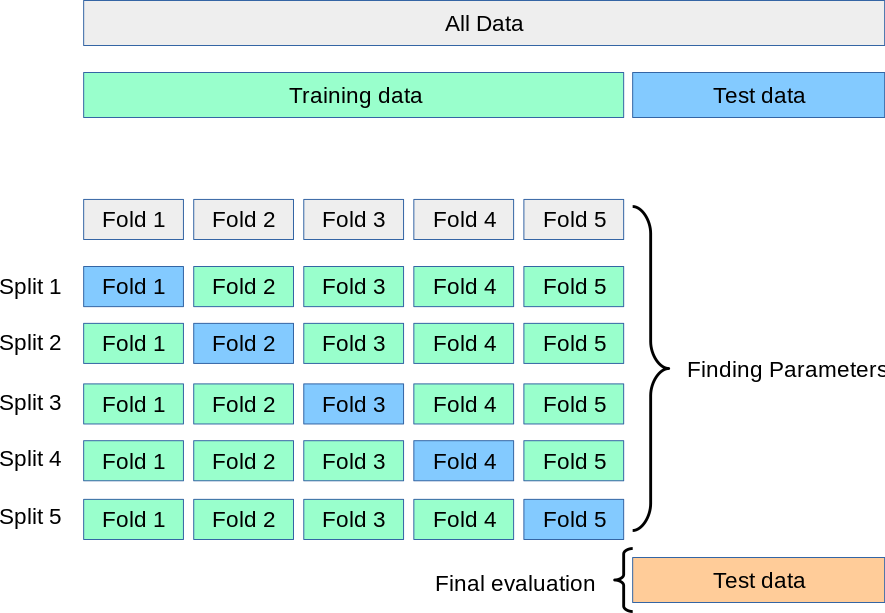

Výhoda tohoto přístupu je, že nevyžaduje tolik dat ("recykluje" totiž data, která máme k dispozici). Nevýhodou může být časová náročnost, a to zvlášť v případě, že prohledáváme hodně různých parametrů.

In [44]:
model = DecisionTreeClassifier()
params = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10], "min_samples_split": [10, 20, 30, 40]}

clf = GridSearchCV(model, params, scoring="accuracy")
clf.fit(X, y)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 6, 'min_samples_split': 20}
0.840631473228297


## Unsupervised learning

Doposud jsme se zabývali klasifikací, jako jednou s podtříd supervized learning, tedy úloh, kde předem známe správné odpovědi. Model se pomocí algoritmu a trénovacích dat, které obsahují tyto správné odpovědi, "naučí" jak jednotlivé třídy vypadají, aby později mohl přiřazovat nová data do tříd. V případě regresní úlohy nová data nedostanou přiřazenou třídu, ale nějakou hodnotu jako reálné číslo. Obecný koncept je ale stejný.

V této lekci se budeme věnovat úlohám bez supervize, tedy takovým, kde **předem neznáme správné odpovědi,** nebo tyto odpovědi vůbec neexistují. 

Příklady takových úloh jsou: 

- rozdělování dat na shluky (clustering), na rozdíl od klasifikačních úloh **ale nevíme o žádném záznamu, do kterého shluku patří, ani nevíme, kolik by takových shluků mělo být,**
- hledání anomálií v datech (tj. hledáme něco neobvyklého, například neobvyklé datové toky v síti nebo podivné údaje z nějakého měřícího zařízení).

### Shlukování dat (clustering)

Na obrázku například vidíme data, nad kterými by se dalo přemýšlet jako nad dvěma nebo třemi shluky. Důležité je, že o žádném údaji nevíme, do kterého shluku by měl patřit! Rozdělení je tedy čistě na nás. Je na nás, na kolik shluků data rozdělíme.

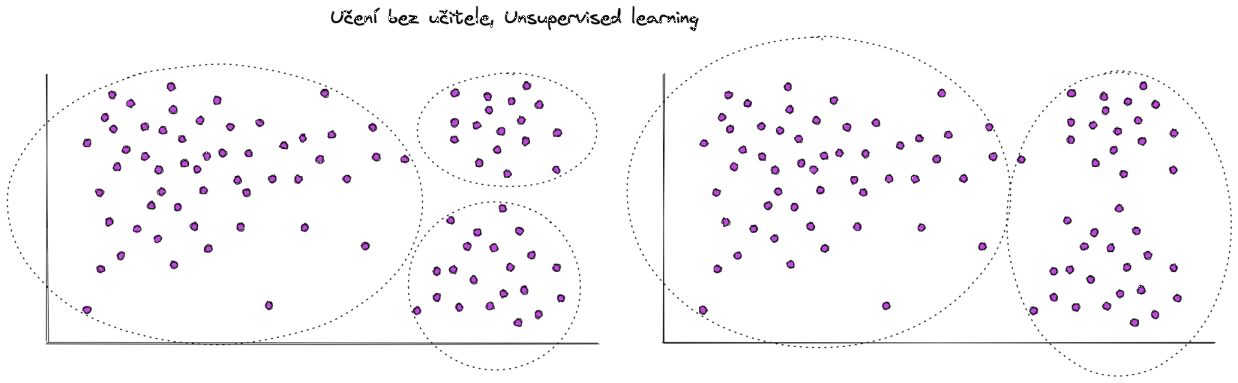

### K-means

Ukážeme si shlukovací algoritmus K-means. _K_ proto, že očekává zadaný počet shluků od uživatele, a _means_ zde znamená průměr - střed shluku neboli _centroid_.

Algoritmus k-means se skládá z následujících kroků:

1. **Výběr počtu shluků (k)**: Algoritmus k-means vyžaduje, abyste předem určili počet shluků, které chcete vytvořit. Počet těchto shluků se označuje jako 'k'. Algoritmus můžeme spouštět opakovaně a různým počtem nastavených shluků a sledovat, jak dobře takový počet "sedí" na naše data.
1. **Náhodná inicializace středů shluků**: Poté, co jsme určili hodnotu 'k', algoritmus náhodně vybere 'k' bodů z datové sady. Tyto body se stávají prvními 'centroidy' - tedy středy shluků.
1. **Přiřazení bodů k nejbližším středům shluků**: Každý bod v datové sadě se nyní přiřadí k tomu centroidu, ke kterému má nejkratší vzdálenost. Tím se vytvoří dočasné shluky.
1. **Přesu středů shluků**: Poté, co jsou všechny body přiřazeny k shlukům, algoritmus spočítá nový střed každého shluku jako průměr všech bodů, které do tohoto shluku patří. Následně je *centroid* přesunutý do středu shluku.
1. **Opakování kroků 3 a 4**: Algoritmus nyní opakuje kroky 3 a 4, dokud se středy shluků nepřestanou posouvat nebo dokud se nevyčerpá předem stanovený počet iterací. Každá iterace upřesňuje středy shluků a přiřazuje body k novým středům.

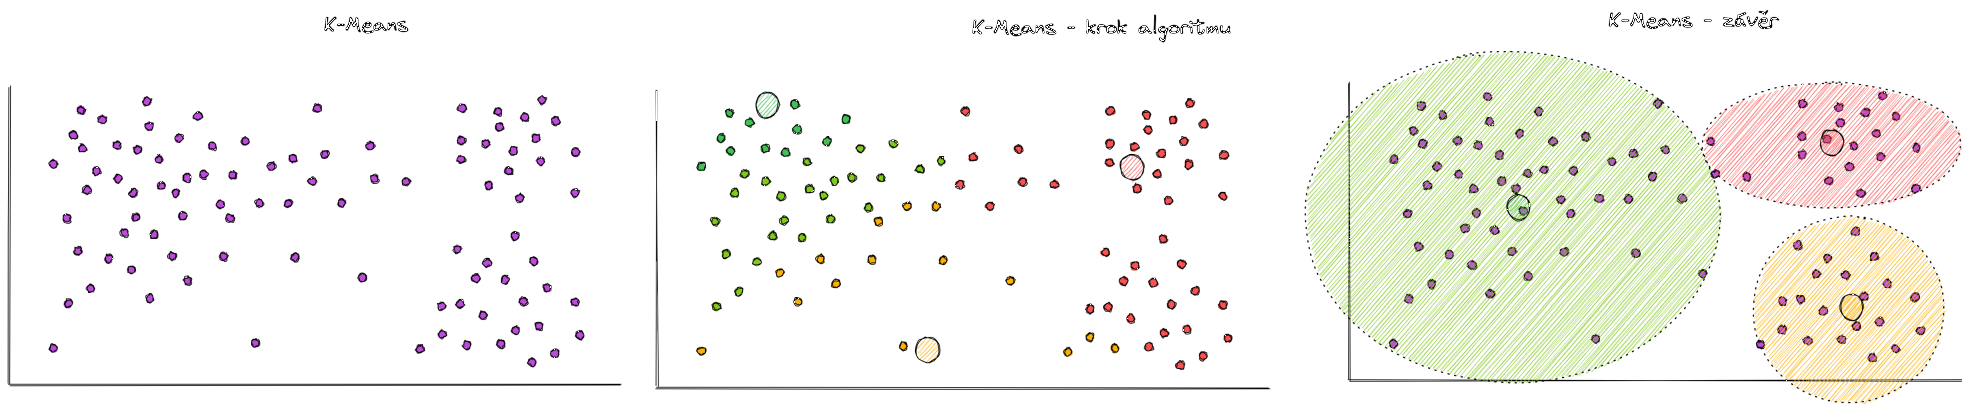

Úloha, která nás bude provázet lekcí, se klasifikace uživatelů kreditních karet, která jsou v souboru [CC_GENERAL.CSV](CC_GENERAL.CSV).

[Zdroj dat](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?resource=download)

Popisy sloupců (features):

* CUST_ID: Identifikace držitele kreditní karty (Kategorické)
* BALANCE: Zůstatek na účtu pro nákupy
* BALANCE_FREQUENCY: Jak často se aktualizuje zůstatek, skóre mezi 0 a 1 (1 = často aktualizováno, 0 = nečasto aktualizováno)
* PURCHASES: Částka nákupů provedených z účtu
* ONEOFF_PURCHASES: Maximální částka nákupu provedená najednou
* INSTALLMENTS_PURCHASES: Částka nákupu provedená na splátky
* CASH_ADVANCE: Hotovost předem poskytnutá uživatelem
* PURCHASES_FREQUENCY: Jak často se provádějí nákupy, skóre mezi 0 a 1 (1 = často nakupováno, 0 = nečasto nakupováno)
* ONEOFFPURCHASESFREQUENCY: Jak často se provádějí nákupy najednou (1 = často nakupováno, 0 = nečasto nakupováno)
* PURCHASESINSTALLMENTSFREQUENCY: Jak často se provádějí nákupy na splátky (1 = často prováděno, 0 = nečasto prováděno)
* CASHADVANCEFREQUENCY: Jak často se platí hotovost předem
* CASHADVANCETRX: Počet transakcí provedených s "Cash in Advanced"
* PURCHASES_TRX: Počet provedených nákupních transakcí
* CREDIT_LIMIT: Limit kreditní karty pro uživatele
* PAYMENTS: Částka platby provedená uživatelem
* MINIMUM_PAYMENTS: Minimální částka plateb provedených uživatelem
* PRCFULLPAYMENT: Procento úplné platby uhrané uživatelem
* TENURE: Doba trvání služby kreditní karty pro uživatele

In [45]:
X = pandas.read_csv("CC_GENERAL.csv")
X.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
4,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [46]:
X = X.head(1000)

Určitě musíme z dat odebrat sloupec `CUST_ID`.

In [47]:
X = X.drop(columns=["CUST_ID"])

In [48]:
X.shape

(1000, 17)

Data musíme určitě normalizovat s využitím `StandardScaler()`. U unsupervised learning nedělíme data na trénovací a testovací, takže normalizujeme všechna data najednou.

In [49]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Snížení dimensionality

U shlukování je vždy dobré si data **vizualizovat**. Jak ale na to? Máme celkem 17 proměnných, to je jako 17-ti dimenzionální prostor. Vizualizovat umíme ve dvou dimenzích, možná i ve třech. V jedenácti ale těžko.

Modul `scikit-learn` má k dispozici nástroje na snížení dimenzionality ("sníže počtu proměnných"). Snížení počtu proměnných má několik výhod. Nejenom, že můžeme pak data snáz vizualizovat, ale zbavíme se problému kolinearity (korelace dvou nebo více proměnných), a navíc snížíme čas a výkon potřebný pro další modelování.

Redukce dimensionality je postup, který se snaží zachovat původní strukturu dat a minimalizovat ztrátu informace, ke které dojde při odebrání některých sloupců.

Jedna z metod, která nám sníží počet proměnných ("redukuje dimenzionalitu") se jmenuje t-SNE (t-distributed Stochastic Neighbor Embedding). Modul `scikit-learn` tuto metodu implementuje, pojďme jí vyzkoušet.

`TSNE` má několik důležitých parametrů:
- `n_components` říká, kolik dimenzí (proměnných) chceme. U t-SNE typicky volíme hodnotu 2 nebo 3.
- `perplexity` určuje, podle kolika sousedů se má metoda t-SNE řídit. Čím vyšší je náš dataset, tím vyšší hodnotu parametru nastavíme. Běžně se používají hodnoty mezi 5 a 50.

Princip metody spočívá v tom, že se snaží při redukci počtu dimenzí udržovat body, které jsou si v původní dimenzi blízké, blízko u sebe. 

In [50]:
tsne = TSNE(
    n_components=2,
    random_state=42,
)
X = tsne.fit_transform(X)

Nyní jsou naše data redukovaná jen do dvou dimenzí:

In [51]:
X.shape

(1000, 2)

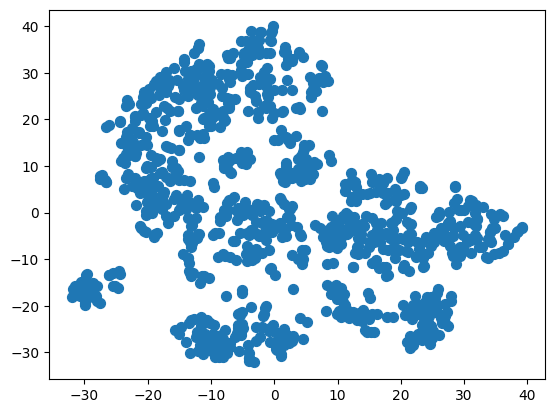

In [52]:
plt.scatter(X[:, 0], X[:, 1], s=50)

Můžeme spustit algoritmus K-means. Uvažujme nyní, že chceme vytvořit 2 shluky.

In [53]:
model = KMeans(n_clusters=2, random_state=42, n_init="auto")
labels = model.fit_predict(X)

Výsledek si můžeme zobrazit graficky. Každý bod obarvíme do barvy dle shluku, do kterého byl přiřazen, a doplníme i centroidy.

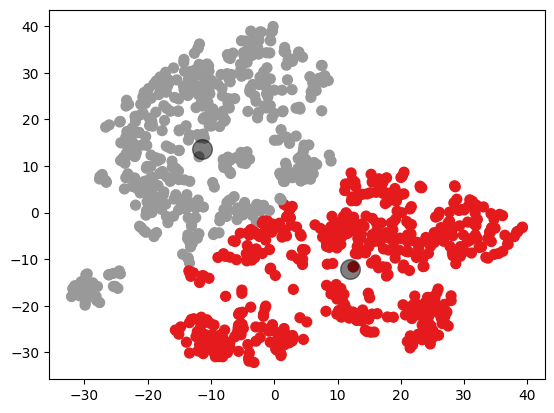

In [54]:
# Zobrazení bodů
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="Set1")
# Zjištění centroidů
centers = model.cluster_centers_
# Zobrazení centroidů
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)

Dva shluky ale nemusejí být to správné číslo. Jak poznat, kolik shluků bychom měli mít? K tomu můžeme využít například metriku `inertia`.  Tato metrika je výpočet sumy kvadratických vzdáleností všech bodů v shluků ke středu shluku, neboli centroidu. Čím více máme shluků, tím spíše bude vzdálenost klesat. Ale je pravděpodobné, že tempo poklesu bude s růstem klastrů klesat. Není tedy naším cílem vytvořit model s obrovským množstvím shluků (takový by nám toho stejně moc neřekl). Ve skutečnosti chceme vybrat počet, ve kterém počet klastrů výrazně zpomaluje.

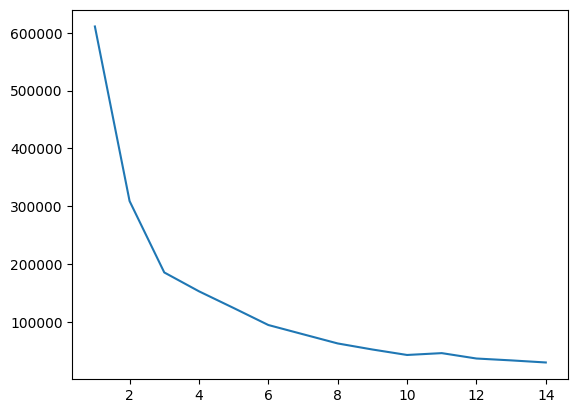

In [55]:
distances = []
cluster_counts = range(1, 15)
 
for k in cluster_counts:
    model = KMeans(n_clusters=k, n_init="auto").fit(X)
    model.fit(X)
    distances.append(model.inertia_)

plt.plot(cluster_counts, distances,)

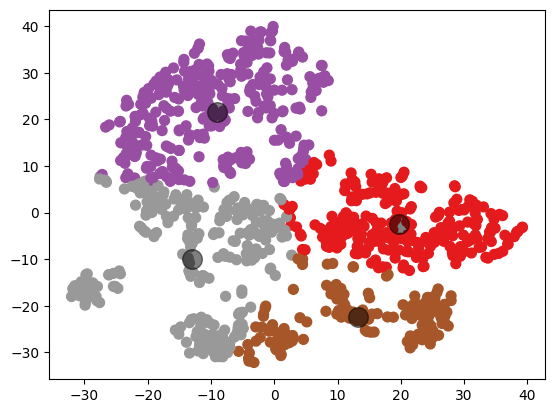

In [56]:
model = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels = model.fit_predict(X)

# Zobrazení bodů
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="Set1")
# Zjištění centroidů
centers = model.cluster_centers_
# Zobrazení centroidů
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)

### Připojení informace o shluku k datům

Cluster můžeme připojit k původním datům. Protože u našich dat jsme provedli redukci dimenzionality a tím pádem ztratili původní sloupce, načteme si data znovu ze souboru. Do pandas tabulky pak můžeme přidat `cluster` každé hodnoty jako sloupec.

In [57]:
X = pandas.read_csv("CC_GENERAL.csv")
X = X.head(1000)
X["cluster"] = labels
X.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,3
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12,3
4,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12,3


# Cvičení

## Vzorky vína

Pracuj se souborem [wine-regions.csv](wine-regions.csv). Každý záznam obsahuje informace o vzorku vína. Všechny vzorky pocházejí z jednoho regionu v Itálii, ale v datech se nachází několik různých odrůd. Naší úlohou bude data uspořádat do shluků, které by mohly odpovídat odrůdám. Na začátku uvažujme, že nevíme, ke které odrůdě jednotlivé záznamy patří, a nevíme ani to, kolik odrůd v datech je.

- Proveď redukci dimenzionality na 2 dimenze. Vykresli data pomocí grafu. Poznáš z grafu, kolik by byl nejlepší počet shluků? Následně zkus určit metriku *inertia* pro 2 až 10 shluků. Pro jaký počet shluků dochází k výraznému sníže tempa jejího poklesu? Následně pro tento počet vykresli graf včetně centroidů.
- Redokce dimenzionality není nutná. Zkus nyní znovu načíst data a vykresli graf metriky *inertia* pro 1 až 10 shluků na datech s původní dimenzí. Změnil se graf nějak výrazně? Změnilo by to tvé rozhodnutí o počtu shluků?

### Bonus

Další metrikou, kterou můžeme využít, je takzvaný _Silhouette_ koeficient. Ten měří průměrnou vzdálenost mezi bodem a všemi body, které jsou ve stejném shluku, a pak vzdálenost mezi bodem a všemi body v nejbližším jiném shluku.

Jeho hodnota se nachází mezi 1 a -1. Čím vyšší je tento koeficient, tím lépe definované jsou clustery (body se nachází blízko svému shluku a daleko od všech ostatních). Pokud má hodnotu kolem nuly, značí to, že se naše shluky překrývají (existují body na rozhraní dvou shluků). Záporná hodnota značí, že body z odlišných shluků jsou si blíže než body ze stejných shluků.

Hodnotu koeficientu zjisíš pomocí funkce `silhouette_score()`. Příklad volání funkce je níže.

```py
silhouette_score(X, labels)
```

Vytvoř graf hodnoty koeficientu pro 2 až 10 shluků. V jakém případě je hodnota koeficientu nejvyšší?

Řešení příkladu je [zde](reseni.ipynb).